In [92]:
using CSV
using DataFrames
using Turing
using MCMCChains
using Plots
using StatsPlots
using StatsBase
using Distributions
using NPZ
using Statistics
using Random

## Importing ##

In [93]:
data_path = "spikeAndBehavioralData/allData/Cori_2016-12-14/"
eye_area = npzread("$(data_path)eye.area.npy")
clusterids = npzread("$(data_path)spikes.clusters.npy")[:] 
spiketimes = npzread("$(data_path)spikes.times.npy")[:]
eyetimes = npzread("$(data_path)eye.timestamps.npy")[:,2]

267759-element Vector{Float64}:
   15.982835732952108
   15.992836839228154
   16.0028379455042
   16.012839051780247
   16.022840158056297
   16.03284126433234
   16.042842370608387
   16.052843476884433
   16.06284458316048
   16.072845689436527
   16.082846795712577
   16.092847901988623
   16.10284900826467
    ⋮
 2693.748894411977
 2693.7588955182528
 2693.768896624529
 2693.778897730805
 2693.7888988370814
 2693.7988999433574
 2693.8089010496333
 2693.8189021559097
 2693.828903262185
 2693.8389043684615
 2693.8489054747374
 2693.8589065810133

## Pre-Processing ##

The first step is to process the data for when each cluster spikes into an array. Each row should represent a cluster and each column should represent a time bin. Each entry to the array is the amount of times that that particular neuron spiked over the period of the time bin (e.g. 1 second).

In [94]:
# count spikes for each cluster
unique_clusterids = sort(unique(clusterids))
nclusters = round(Int, length(unique_clusterids)/10) # number of clusters (Reduced for debugging)
binedges = -0.5 .+ append!(unique_clusterids,clusterids[end]+1)
h_spikecounts = StatsBase.fit(Histogram,clusterids[:],binedges)
spikecounts = h_spikecounts.weights
spikerates = spikecounts./maximum(spiketimes)

# get spike counts per timebin
dt = 1 # seconds
maxtime = maximum(spiketimes)
timebin_edges = (20:dt:maxtime-20)
nt = length(timebin_edges)
spikecount_matrix = Array{Int64}(undef,nclusters,nt-1)

for i = 1:nclusters
    inds = findall(clusterids.==i*9) # Edited for debigging with a smaller sample
    htemp = StatsBase.fit(Histogram,spiketimes[:][inds],timebin_edges)
    spikecount_matrix[i,:] = htemp.weights
end


The second step is to reformat the eye area data to rescale the time frame. This is necessary as the eye area data was captured using a camera the cluster spiketimes was captured using a neuropixel probe, meaning that although they record for the same time period, the time scales are incorrect. 

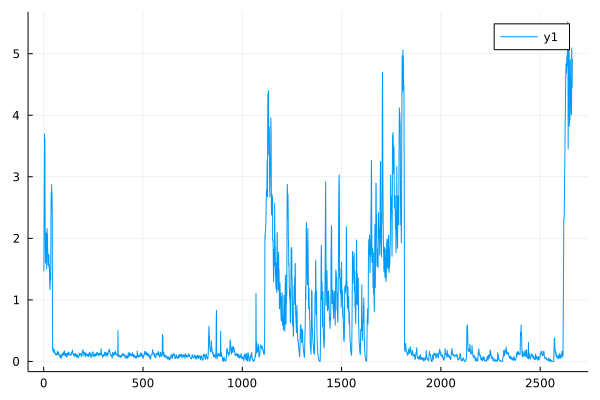

In [95]:
# Remove all negative areas from the eye_area data
for i in 1:length(eye_area)
    if eye_area[i] < 0
        eye_area[i] = 0
    end
end

# Define the bounderies for the timebins for eye areas
dt = 1 # seconds
maxtime = maximum(spiketimes)
timebin_edges = (20:dt:maxtime-20)
nt = length(timebin_edges)
eye_area_bin = zeros(Float32, nt-1)

# Generate the average eye area for each time bin.
j = 1
for i in 1:nt-1
    count = 0
    while eyetimes[j] <= timebin_edges[i+1]
        if eyetimes[j] >= timebin_edges[i]
            eye_area_bin[i] += eye_area[j]
            count += 1
        end
        j += 1
    end
    eye_area_bin[i] /= count
end

plot(eye_area_bin)

We are now left with eye area averages which correspond to the same time period as each spikecount for each neuron. 

The number of clusters is 108
Number of timebins is 2662
There is a Pearson correlation coefficient of 0.13792306 between the two data


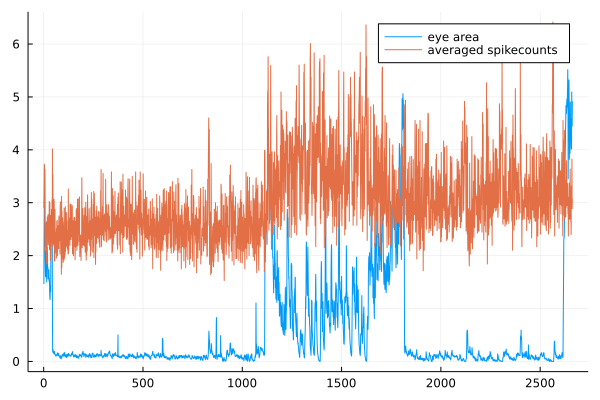

In [96]:
# spikecount_matrix[cluster index, time bin index]
n_clusters = length(spikecount_matrix[:,1])
n_timebins = length(spikecount_matrix[1,:])

println("The number of clusters is $(n_clusters)")
println("Number of timebins is $(n_timebins)")

summed_spikecounts = zeros(Float32, length(spikecount_matrix[1,:]))
for cluster in 1:length(spikecount_matrix[:,1])
    summed_spikecounts += spikecount_matrix[cluster,:]
end

average_spikecounts = summed_spikecounts ./ length(spikecount_matrix[:,1])

println("There is a Pearson correlation coefficient of ", cor(average_spikecounts, eye_area_bin), " between the two data")

plot(eye_area_bin, label="eye area")
plot!(average_spikecounts, label="averaged spikecounts")

In [98]:
spikecount_array = []
# Turn the matrix into a vector
for i in 1:n_clusters
    spikecount_array = cat(dims=1, spikecount_array, spikecount_matrix[i,:])
end

# Check that the logic of inlining the matrix is correct
@assert spikecount_array[1:n_timebins] == spikecount_matrix[1,:]
@assert length(spikecount_array) == n_clusters*n_timebins

# Create ids to label each spikecount
cluster_ids = [i for i in 1:n_clusters for j in 1:n_timebins]
timebin_ids = [j for i in 1:n_clusters for j in 1:n_timebins]

# Normalise eye area
eye_area_bin = eye_area_bin ./ std(eye_area_bin; dims=1)

2662-element Vector{Float32}:
 1.5386262
 2.4067316
 3.0055072
 3.889136
 3.723729
 3.815971
 2.328185
 1.8875943
 1.692958
 1.6786237
 2.0222278
 2.1937656
 1.7610837
 ⋮
 4.773609
 5.1567745
 4.5127625
 4.823503
 4.551715
 4.265016
 4.2201533
 4.218891
 5.355695
 4.883414
 4.678903
 5.171094

## Modelling

$$y_{i, j} \sim Poisson(\lambda_{i,j})$$

$$\lambda_{i,j} = exp(\alpha + \alpha_i * eye\_area_j \cdot \beta_j \cdot \tau_\beta)$$

$$\alpha \sim Normal(mean(y), std(y))$$

$$\alpha_i \sim Normal(0, \tau_\alpha)$$

$$\beta_j \sim Normal(0, 1)$$

$$\tau_\alpha \sim Cauchy^+(0, 2)$$

$$\sigma \sim Exponential(1/std(y))$$

In [99]:
@model function firing_model(spikecount_array, cluster_ids, timebin_ids, eye_area_bin, n_clusters, n_timebins)

    # Priors
    # α ~ Normal(mean(spikecount_array), 2.5 * std(spikecount_array))
    β ~ Normal(0, 1)

    τ_α ~ truncated(Cauchy(0, 2), 0, Inf)
    τ_β ~ truncated(Cauchy(0, 2), 0, Inf)
    α_i ~ filldist(Gamma(2, 2), n_clusters)
    β_i ~ filldist(Gamma(2, 2), n_clusters)

    for i in 1:n_clusters
        for j in 1:n_timebins
            λ = τ_α * α_i[cluster_ids[i]] + eye_area_bin[timebin_ids[j]] * β_i[cluster_ids[i]] * τ_β
            spikecount_array[((i-1)*n_timebins)+j] ~ Poisson(λ)
        end
    end
    
    return spikecount_array 
end

firing_model (generic function with 2 methods)

In [100]:
model = firing_model(spikecount_array, cluster_ids, timebin_ids, eye_area_bin, n_clusters, n_timebins)

DynamicPPL.Model{typeof(firing_model), (:spikecount_array, :cluster_ids, :timebin_ids, :eye_area_bin, :n_clusters, :n_timebins), (), (), Tuple{Vector{Any}, Vector{Int64}, Vector{Int64}, Vector{Float32}, Int64, Int64}, Tuple{}, DynamicPPL.DefaultContext}(firing_model, (spikecount_array = Any[0, 0, 1, 0, 1, 2, 0, 0, 1, 0  …  1, 1, 1, 4, 1, 0, 6, 4, 2, 0], cluster_ids = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  108, 108, 108, 108, 108, 108, 108, 108, 108, 108], timebin_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662], eye_area_bin = Float32[1.5386262, 2.4067316, 3.0055072, 3.889136, 3.723729, 3.815971, 2.328185, 1.8875943, 1.692958, 1.6786237  …  4.5127625, 4.823503, 4.551715, 4.265016, 4.2201533, 4.218891, 5.355695, 4.883414, 4.678903, 5.171094], n_clusters = 108, n_timebins = 2662), NamedTuple(), DynamicPPL.DefaultContext())

In [101]:
chain = sample(model, NUTS(0.65), MCMCThreads(), 1000, 1)